In [15]:
import matplotlib.pyplot as plt
import numpy as np
from exotic_ld import StellarLimbDarkening
from astropy.modeling.fitting import LevMarLSQFitter
import lmfit
from scipy import stats
from astropy.io import fits
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker
import batman 
import xarray as xr
import netCDF4
import h5netcdf
import json
from astropy.utils.misc import JsonCustomEncoder
import os
from cycler import cycler
import pandas as pd

In [ ]:
j = 0.102763 # solar radii in a jupiter radius 
rp = 1.319 # jupiter radii
rs = 1.17 # solar radii

(j*rp)/rs #convert jupiter radii to solar radii

0.11584991196581196

In [ ]:
#get the wavelength ranges for bins
bins = pd.read_csv('TOI134_01_60pix_bins.txt', skiprows=1, sep=' ', names=['short', 'long', 'center', 'width'])

In [ ]:
# specify the file name, path, save path, and information about the target 
spec_file = 'toi134b-nrs2.xc'
name=spec_file.split('.')[0]
lc_dir = './lcs/'

if os.path.isdir('./outputs/'+name) is False:
    os.mkdir('./outputs/'+name)
save_dir = './outputs/'+name+'/'

grating = 'G395H' 
ld_model = 'mps1'
ld_type = 'nonlinear'
# ld_type = 'quadratic'

'''parameters for limb darkening calculations'''
Teff = 3842  
logg = 4.84 
M_H = -.03 #metallicity

'''transit parameters'''  #using parameters consistent with MIRI results 
T0       = 60113.88027683486           # BJD time of inferior conjunction
period   = 1.401526                        # orbital period (days) BJD_TDB
Rp       = 0.025738585287486525                 # planet radius (in units of stellar radii)
aRs      = 4.005871895235393              # semi-major axis (input a/Rs so units of stellar radii) 
inc      = 77.00902477777493            # orbital inclination
ecc      = 0.0                              # eccentricity
omega    = 0                             # longitude of periastron

rho_star = (3*np.pi)/(6.67259e-8*(period*86400)**2)*(aRs)**3     # stellar density (g/cm^3) from a/Rs

In [19]:
def get_wlc(filename):
    '''
    Read in white light curve 
    
    ======
    INPUT: 
    ======
    - filename for xarray file

    ======    
    OUTPUT: 
    ======
    - time (BJD_TDB), raw_flux, raw_flux_error, 
    shift_x, shift_y
    '''
    
    #read in xarray file
    ds = xr.open_dataset(lc_dir+filename, engine='h5netcdf')
    
    #pull out arrays
    times = ds['time_flux'].values

    flux = np.sum(ds['flux'].values, axis=1)
    flux_err = np.sum(ds['flux_error'].values, axis=1)

    mn = np.mean(flux[flux>1.6e7][:100])
    flux=flux/mn
    
    # flux = ds['flux'].values
    # flux_err = ds['flux_error'].values
    
    x = ds['x_shift'].values
    y = ds['y_shift'].values
    quality_flag = ds['quality_flag'].values
    wavelength = ds['wavelength'].values

    ixs=np.where((flux > .98) & (flux < 1.1))
    flux=flux[ixs]
    flux_err=flux_err[ixs]
    times=times[ixs]
    x=x[ixs]
    y=y[ixs]

    return times,flux,flux_err,x,y,quality_flag,wavelength

the next four cells were used when binning the light curves. they are commented out as it stands because they are not useful to run every time (for instance, if you just want to fit a white light curve). 

NRS2 data has a lot of outliers, and I was having trouble with the masking as written in `fit_white_light_curve()`, so I brute forced it by normalizing the light curves selectively, so that the outliers do not affect the mean, and cutting out the indices where flux was too large (a determination made by eye). 

In [20]:
# def get_ixs(filename):
#     ds = xr.open_dataset(lc_dir+filename, engine='h5netcdf')
    
#     #pull out arrays
#     times = ds['time_flux'].values

#     flux = np.sum(ds['flux'].values, axis=1)
#     flux_err = np.sum(ds['flux_error'].values, axis=1)

#     mn = np.mean(flux[flux<1e7][:100])
#     flux=flux/mn

#     ixs=np.where((flux > .96) & (flux < 2))

#     return ixs

with those indices, you can trim the data to remove the outliers, and then check to make sure all the shapes match.

In [21]:
# ixs = get_ixs(spec_file)

# times,flux,flux_err,x,y,quality_flag,wavelength = get_wlc(spec_file)
# flux=flux[ixs]
# flux_err=flux_err[ixs]
# times=times[ixs]
# x=x[ixs]
# y=y[ixs]
# quality_flag=quality_flag[ixs]

# print(flux.shape)
# print(flux_err.shape)
# print(times.shape)
# print(x.shape)
# print(y.shape)
# print(quality_flag.shape)
# print(wavelength.shape)

the next two cells were to bin the now-trimmed light curves. the first chops the data up by bin and saves it in 2d numpy arrays; the second saves those numpy arrays as an xarray.

In [22]:
# wlmin = 3.819918
# wlmax = 5.082485

# bins = bins[bins.short>=wlmin].reset_index()

# binflux = np.empty((0,len(flux))) #help
# binfluxerr = np.empty((0,len(flux_err)))
# binflag = np.empty((0,len(quality_flag)))
# binstarts = np.array([])
# binends = np.array([])

# for i in range(len(bins)):
#     wl1=bins.short[i]
#     wl2=bins.long[i]
#     ixs=np.where((wavelength>=wl1) & (wavelength<=wl2))[0]
#     nflux = flux[:,ixs].sum(axis=1)
#     nflux_err = flux_err[:,ixs].sum(axis=1)
#     nflag = np.logical_and.reduce(quality_flag[:,ixs], axis=1)
#     binflux = np.vstack((binflux, nflux))
#     binfluxerr = np.vstack((binfluxerr, nflux_err))
#     binflag = np.vstack((binflag, nflag))
#     binstarts = np.append(binstarts, wl1)
#     binends = np.append(binends, wl2)

# print(binstarts)
# print(binends)

In [23]:
# ds_spec = xr.Dataset()
        
# ds_spec = xr.Dataset(
#         #data is a function of two dimensions
#         data_vars=dict(flux=(["bins", "times"], binflux,{'units': ''}),
#                        flux_error=(["bins", "times"], binfluxerr,{'units': ''}),
#                        quality_flag=(["bins", "times"], binflag,{'units': ''}),
#                        x=(["times"], x, {'units':''}),
#                        y=(["times"], y, {'units':''})
#                       ),
#         coords=dict(
#             time_flux=(["time_flux"], times,{'units': 'bjd'}),
#             bin_starts=(["bin_start"], binstarts, {'units': 'AA'}),
#             bin_ends=(["bin_end"], binends, {'units': 'AA'})
#         ),
#         attrs=dict(author="S. von Coelln",#required
#                    contact="svoncoelln@stsci.edu",#required,
#                    code="aesop",#could also insert github link
#                    data_origin=json.dumps({'wlc':'wasp178b-nrs1.xc' }), #required
#                    normalized="True",
#                    notes="NRS1 spectral light curves",
#                   )
#     )
    
# ds_spec.to_netcdf(save_dir+name+'.xc')

In [24]:
def noise_calculator(data,wl1_nrs2,wl2_nrs2,maxnbins=None,binstep=1):
    """
    Author: Hannah R. Wakeford, University of Bristol
    Email: hannah.wakeford@bristol.ac.uk
    Citation: Laginja & Wakeford, 2020, JOSS, 5, 51 (https://joss.theoj.org/papers/10.21105/joss.02281)
    
    Calculate the noise parameters of the data by using the residuals of the fit
    :param data: array, residuals of (2nd) fit
    :param maxnbins: int, maximum number of bins (default is len(data)/10)
    :param binstep: bin step size
    :return:
        red_noise: float, correlated noise in the data
        white_noise: float, statistical noise in the data
        beta: float, scaling factor to account for correlated noise
    """

    plt.rcParams['figure.figsize'] = [10.0, 7.0] 

    # bin data into multiple bin sizes
    npts = len(data)
    if maxnbins is None:
        maxnbins = npts/10.

    # create an array of the bin steps to use
    binz = np.arange(1, maxnbins+binstep, step=binstep, dtype=int)

    # Find the bin 2/3rd of the way down the bin steps
    midbin = int((binz[-1]*2)/3)

    nbins = np.zeros(len(binz), dtype=int)
    standard_dev = np.zeros(len(binz))
    root_mean_square = np.zeros(len(binz))
    root_mean_square_err = np.zeros(len(binz))
    
    for i in range(len(binz)):
        nbins[i] = int(np.floor(data.size/binz[i]))
        bindata = np.zeros(nbins[i], dtype=float)
        
        # bin data - contains the different arrays of the residuals binned down by binz
        for j in range(nbins[i]):
            bindata[j] = np.mean(data[j*binz[i] : (j+1)*binz[i]])

        # get root_mean_square statistic
        root_mean_square[i] = np.sqrt(np.mean(bindata**2))
        root_mean_square_err[i] = root_mean_square[i] / np.sqrt(2.*nbins[i])
      
    expected_noise = (np.std(data)/np.sqrt(binz)) * np.sqrt(nbins/(nbins - 1.))
 
    final_noise = np.mean(root_mean_square[midbin:])
    base_noise = np.sqrt(final_noise**2 - root_mean_square[0]**2 / nbins[midbin])

    # Calculate the random noise level of the data
    white_noise = np.sqrt(root_mean_square[0]**2 - base_noise**2)
    # Determine if there is correlated noise in the data
    red_noise = np.sqrt(final_noise**2 - white_noise**2 / nbins[midbin])
    # Calculate the beta scaling factor
    beta = np.sqrt(root_mean_square[0]**2 + nbins[midbin] * red_noise**2) / root_mean_square[0]

    # If White, Red, or Beta return NaN's replace with 0, 0, 1
    white_noise = np.nan_to_num(white_noise, copy=True)
    red_noise = np.nan_to_num(red_noise, copy=True)
    beta = 1 if np.isnan(beta) else beta
    
    # Plot up the bin statistic against the expected statistic
    # This can be used later when we are setting up unit testing.
    plt.figure()
    plt.errorbar(binz, root_mean_square, yerr=root_mean_square_err, color='gray', lw=1.5, label='RMS')
    plt.plot(binz, expected_noise, color='purple', ls='-', lw=2, label='expected noise')
    
    plt.title('Expected vs. measured noise binning statistic ({}-{})'.format(wl1_nrs2,wl2_nrs2))
    plt.xlabel('Number of bins',fontsize=14)
    plt.ylabel('RMS',fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(save_dir+'RMS_bins_{}-{}.pdf'.format(wl1_nrs2,wl2_nrs2))
    plt.close()

    return white_noise,red_noise,beta

In [25]:
def get_3D_LD_nonlinear(M_H,Teff,logg,wl_range):
    '''
    Compute theoretical 3D non-linear limb darkening coefficients 
    using ExoTiC-LD (https://github.com/Exo-TiC/ExoTiC-LD). 
    
    ======
    INPUT: 
    ======
    - stellar model parameters (metallicity [dex], effective temperature [K], surface gravity [dex])
    - wavelength range (Angstroms)

    ======    
    OUTPUT: 
    ======
    - 3D limb darkening coefficients
    '''
    
    #define path to stellar models & instrument throughputs 
    ld_data_path = ''
    # ld_data_path = '/data/malam/exotic-ld_data/'
    # ^^ i left this blank bc newer versions of exotic-ld say they download the necessary files at runtime
    
    #set stellar parameters 
    ld_model = 'mps1'
    stellar_ld = StellarLimbDarkening(M_H,Teff,logg,ld_model,ld_data_path)
    
    #set instrument mode
    mode = 'JWST_NIRSpec_G395H'
    
    #compute LD coefficients 
    c1,c2,c3,c4 = stellar_ld.compute_4_parameter_non_linear_ld_coeffs(wl_range,mode)

    # print('3D non-linear limb darkening coefficients for: ',wl_range[0],'-',wl_range[1],'\AA')
    # print('c1 = ',c1)
    # print('c2 = ',c2)
    # print('c3 = ',c3)
    # print('c4 = ',c4)

    ld_coeffs = np.array([c1,c2,c3,c4])
    
    # #save limb darkening coefficients to a text file
    # ld_file = 'LD_coefficients_nonlinear.txt'
    # np.savetxt(ld_file,np.c_[wl_range[0]*1e-4,wl_range[1]*1e-4,np.mean([wl_range[0],wl_range[1]])*1e-4,c1,c2,c3,c4],fmt='%0.4f',delimiter=' ',header='# wl_lower  wl_upper  wl_mid  c1  c2  c3  c4')

    return ld_coeffs

In [ ]:
def fit_white_light_curve(times, flux, flux_err, x, y, sys_select,ld_coefs, law, planet_params,sys_params=np.array([1.,0.,0.,0.,0.]),outlier_threshold=5.,draw_fits=True):
    
    sys_fit = np.empty(len(sys_params), dtype=float)

    params = batman.TransitParams()
    params.t0 = planet_params['t0']
    params.per = planet_params['period']  # fixed.
    params.rp = planet_params['rp'] #rp/rs
    params.a = planet_params['a_rs'] #a/r*
    params.inc = planet_params['inclination']
    params.ecc = planet_params['eccentricity']  # fixed.
    params.w = planet_params['w_omega']  # fixed.
    params.u = ld_coefs  # fixed.
    params.limb_dark = law  # fixed.
    m = batman.TransitModel(params, times)

    _iter = 0
    mask = np.ones(times.shape).astype(bool)
    
    while True:
        def model(_, t0, rp, a, inc, s0=None, s1=None, s2=None, s3=None, s4=None, use_mask=False):

            # Free physical params.
            params.t0 = t0
            params.rp = rp
            params.a = a
            params.inc = inc
            light_curve = m.light_curve(params)

            # Systematics
            if (sys_select == 'x_y'):
                sys = s0 + (s1 * x) + (s2 * y) + (s3 * times)
            if (sys_select == 'xy'):
                aby = abs(y-np.median(y))
                sys = s0 + (s1 * (x*aby)) + (s2 * times)
                print('s2 is slope: ', s2)
            if (sys_select == 'xyt2'):
                aby = abs(y-np.median(y))
                sys = s0 + (s1 * (x*aby)) + (s2*times + s3*times*times)
            if (sys_select == 'ramp'):
                sys = s0 - np.exp(-s1 * times + s2) + (s3 * times)            
            
            light_curve[:] *= sys

            if use_mask:
                return light_curve#[mask]
            else:
                return light_curve

        _iter += 1       
        p0_guess = [planet_params['t0'], planet_params['rp'], planet_params['a_rs'], planet_params['inclination']]
        p0_guess.extend(sys_params.tolist())
        popt, pcov = curve_fit(
            model, times, flux, sigma=flux_err,
            p0=p0_guess,
            method='trf')

        perr = np.sqrt(np.diag(pcov))
        rp = popt[1]
        rp_err = perr[1]
        transit_depth = rp**2
        transit_depth_err = rp_err/rp * 2 * transit_depth
        print('Rp/Rs={} +- {}'.format(rp, rp_err))
        print('Transit depth={} +- {}'.format(transit_depth, transit_depth_err))
        print('t0={}'.format(popt[0]))
        print('a={}'.format(popt[2]))
        print('inc={}'.format(popt[3]))

        opt_model = model(times, *popt)
        residuals = flux - opt_model
        print('Residuals={} ppm'.format(np.std(residuals) * 1.e6))
        dev_trace = np.abs(residuals) / np.std(residuals)
        dev_trace = np.ma.array(dev_trace, mask=~mask)
        max_deviation_idx = np.ma.argmax(dev_trace)

        if dev_trace[max_deviation_idx] > outlier_threshold:
            mask[max_deviation_idx] = False
            continue
        else:
            break

    if draw_fits:
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7))
        # ax1.get_shared_x_axes().join(ax1, ax2)
        # ax1.errorbar(times[mask], flux[mask], yerr=flux_err[mask], fmt='.', zorder=0, alpha=0.2)
        # ax1.plot(times, opt_model, zorder=1)
        # ax2.errorbar(times[mask], residuals[mask], yerr=flux_err[mask], fmt='.')
        # plt.tight_layout()
        # plt.show()
        
        #plot the raw data, transit model, transit + systematics model, & residuals
        # fig = plt.figure()
        # gs = fig.add_gridspec(2,1,hspace=0.00, wspace=0.00)
        # gs = fig.add_gridspec(3,1,hspace=0.00, wspace=0.00)
        fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
        plt.subplots_adjust(hspace=0)

        #raw data + full systematics model
        # ax1 = fig.add_subplot(gs[0,:])
        ax1.errorbar(times, flux, yerr=0, fmt='.', zorder=0, alpha=.2, label='raw flux', color='gray')
        # ax1.errorbar(times[mask], flux[mask], yerr=0, fmt='.', zorder=0, alpha=0.2)
        ax1.plot(times, opt_model, zorder=1, color='purple', label='transit + systematics')

        ax1.set_ylabel('Relative Flux',fontsize=14)
        # plt.title('NRS1 White Light Curve ($\lambda=$'+str(round(wl1,3))+' - '+str(round(wl2,3))+' $\mu$m)')
        ax1.legend(frameon=False,loc='lower left')
        # ax1.set_ylim(flux.min()*0.999, flux.max()*1.001)
        ax1.set_xlim(times.min()-0.001, times.max()+0.001)
    
        # #systematics corrected light curve
        # ax2 = fig.add_subplot(gs[1,:])
        # ax1.errorbar(times[mask], flux[mask]/sys_model, yerr=flux_err[mask], fmt='.', zorder=0, alpha=0.2, label='raw flux', color='gray')
        # # ax2.plot(times,,color='purple')
        #
        # ax2.set_ylabel('Relative Flux',fontsize=14)
        # ax2.legend(frameon=False,loc='lower left')
        # ax2.set_ylim(flux.min()*0.999, flux.max()*1.001)
        # ax2.set_xlim(times.min()-0.001, times.max()+0.001)

        #residuals
        # ax2 = fig.add_subplot(gs[1,:])
        ax2.errorbar(times, (residuals)*1e6, yerr=0, fmt='.',color='gray', alpha=0.2)
        # wsb,wsb_bin_edges,binnumber = stats.binned_statistic(x,residppm,bins=256)
        # ax3.scatter(wsb_bin_edges[1:],wsb,linewidth=2,alpha=0.75,facecolors='r',edgecolors='None',marker='o',zorder=25)

        # ax2.plot([time.min(),time.max()],[0,0],color='purple',zorder=10)
        # ax2.plot([time.min(),time.max()],[np.std(residuals),np.std(residuals)],linestyle='--',color='purple',zorder=15)
        # ax2.plot([time.min(),time.max()],[-1*np.std(residuals),-1*np.std(residuals)],linestyle='--',color='purple',zorder=20)
           
        ax2.set_xlabel('BJD (days)',fontsize=14)
        ax2.set_ylabel('Residuals (ppm)',fontsize=14)
        ax2.axhline(y=0,color='purple',linewidth=2)
        # ax2.set_xlim(times.min()-0.001, times.max()+0.001)
        ax2.set_ylim(-700,700)

        plt.savefig(save_dir+'plot.png')
        
        savefile = 'TOI134_v1_JWST_NIRSpec_G395H_lcfits_NRS2.pdf'
        
        
    ds_nrs2 = xr.Dataset()
        
    ds_nrs2 = xr.Dataset(
        #data is a function of two dimensions
        data_vars=dict(raw_flux=(["times"], flux,{'units': ''}),
                       raw_flux_error=(["times"], flux_err,{'units': ''}),
                       final_model=(["times"], opt_model,{'units': ''}),
                       resid=(["times"], residuals,{'units': ''}) 
                      ),
        coords=dict(
            time_flux=(["time_flux"], 
                                 times,{'units': 'bjd'}),
        ),
        attrs=dict(author="M. Alam",#required
                   contact="malam@stsci.edu",#required,
                   code="aesop",#could also insert github link
                   data_origin=json.dumps({'wlc':'Alam-raw-WLC-TOI134_v1-G395H-NRS2.xc' }), #required
                   normalized="True",
                   notes="NRS1 white light curve fit.",
                  )
    )
    
    ds_nrs2.to_netcdf(save_dir+'fit.xc')
    

    t0 = popt[0]
    a = popt[2]
    inc = popt[3]
    sys_fit = popt[4:]
    print('sys_fit values = ', sys_fit)
    print('slope: ', popt[6])
    print('slope error: ', perr[6])

    with open(save_dir+'params.txt', 'w') as f:
        f.write('Rp/Rs={} +- {}'.format(rp, rp_err))
        f.write('\n')
        f.write('Transit depth={} +- {}'.format(transit_depth, transit_depth_err))
        f.write('\n')
        f.write('t0={}'.format(popt[0]))
        f.write('\n')
        f.write('a={}'.format(popt[2]))
        f.write('\n')
        f.write('inc={}'.format(popt[3]))
        f.write('\n')
        f.write('Residuals={} ppm'.format(np.std(residuals) * 1.e6))
        f.write('\n')
        f.write(f'sys_fit values = {sys_fit}')


    no_planet_popt = np.copy(popt)
    no_planet_popt[1] = 0.
    sys_model = model(times, *no_planet_popt, use_mask=False)

    fit_dict = {
        "light_curve_model": opt_model,
        "corrected_flux": flux - sys_model + 1,
        "corrected_flux_error": flux_err,
        "systematic_model": sys_model,
        "residual": residuals,
    }

    return t0, a, inc, sys_fit, fit_dict

In [27]:
#get ld coefficients 

def fit_nrs2(filename,wl1,wl2):
    
    #read in xarray file 
    times,flux,flux_err,x,y,quality_flag,wavelength = get_wlc(filename)
    
    #make dictionary of planet params
    planet_params = {"t0":T0, "period":period, "rp":Rp, "a_rs":aRs, "inclination":inc, "eccentricity":ecc, "w_omega":omega}
    
    ld_coefs = get_3D_LD_nonlinear(M_H=M_H,Teff=Teff,logg=logg,wl_range=[wl1*1e4,wl2*1e4])
    
    fit_white_light_curve(times,flux,flux_err,x,y,'xy',ld_coefs,'nonlinear',planet_params,sys_params=np.array([1.,0.,0.,0.,0.]),outlier_threshold=5.,draw_fits=True)

s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  1.4901161193847656e-08
s2 is slope:  0.0
s2 is slope:  0.0
s2 is slope:  -1.00000069834987
s2 is slope:  -0.2500001523970899
s2 is slope:  -0.06249999381324008
s2 is slope:  0.015624865928074888
s2 is slope:  0.0039057333494252294
s2 is slope:  0.0009745886528212244
s2 is slope:  0.00023706245879782573
s2 is slope:  3.990602099006486e-05
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.989857122585985e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  3.974955961392137e-06
s2 is slope:  1.3841023612322565e-05
s2 is slope:  5.816646955118226e-06
s2 is slope:  5.816646955118226e-06
s2 is slope:  5.816646955118226e-06
s2 is slope:  5

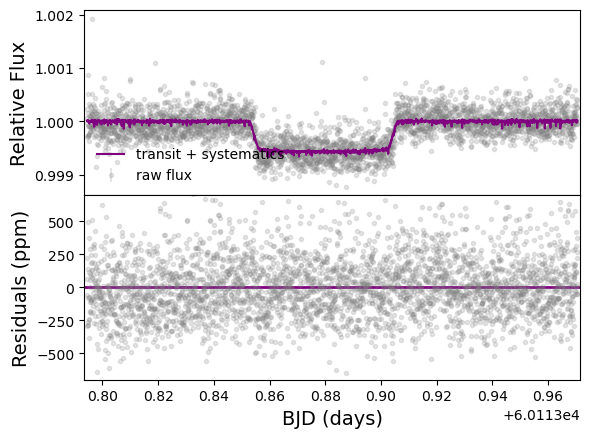

In [28]:
wl1 = 3.819918
wl2 = 5.082485

fit_nrs2(spec_file, wl1, wl2)